In [1]:
try: 
    import torchbearer
except:
    !pip install torchbearer
import torch
import torchbearer
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
# load (download if needed) the MNIST dataset
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

     |████████████████████████████████| 143kB 2.8MB/s 


In [2]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
class_counts = torch.zeros(10, dtype=torch.int32)
for (images, labels) in trainloader:
  for i in range(len(labels)):
    class_counts[labels[i]]+=1

    

In [0]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [20]:
# build the model 
model = BaselineModel(784, 3000, 10)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())
test_acc=np.zeros(30)
test_loss=np.zeros(30)
train_acc=np.zeros(30)
train_loss=np.zeros(30)
# the epoch loop
for epoch in range(30):
    running_loss = 0.0  
    train_correct = 0
    train_total = 0
    for data in trainloader:
      # get the inputs
      inputs, labels = data
      # zero the parameter gradients
      optimiser.zero_grad()
      # forward + loss + backward + optimise (update weights)
      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimiser.step()
      # keep track of the loss this epoch
      running_loss += loss.item()
      # Compute the model accuracy on the test set
      train_total += inputs.shape[0]
      for i in range(len(outputs)):
        #print(outputs[i][int(labels[i])])
        if outputs[i][labels[i]]>=0.5: 
          train_correct +=1
    train_loss[epoch]=running_loss
    train_acc[epoch]=((100.0 * train_correct) / train_total)
    test_correct = 0
    test_total = 0
    # YOUR CODE HERE
    test_lossing=0.0
    for data in testloader:
        # get the inputs
        inputs, labels = data #128*784 128
        # zero the parameter gradients
        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs) #128*10
        loss=loss_function(outputs, labels)
        test_total += inputs.shape[0]
        for i in range(len(outputs)):
          #print(outputs[i][int(labels[i])])
          if outputs[i][labels[i]]>=0.5: 
            test_correct +=1
        test_lossing += loss.item()
    test_acc[epoch]=((100.0 * test_correct) / test_total)
    test_loss[epoch]=test_lossing
    print('Epoch %d,Train Accuracy:%2.2f%%,Test Accuracy:%2.2f%%, Train loss %4.2f, Test Loss %4.2f' % (epoch,(100.0 * train_correct) / train_total,(100.0 * test_correct) / test_total,running_loss,test_lossing))
    #print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')


Epoch 0,Train Accuracy:98.05%,Test Accuracy:99.31%, Train loss 103.87, Test Loss 7.96
Epoch 1,Train Accuracy:99.52%,Test Accuracy:99.44%, Train loss 37.51, Test Loss 6.34
Epoch 2,Train Accuracy:99.73%,Test Accuracy:99.45%, Train loss 21.55, Test Loss 6.17
Epoch 3,Train Accuracy:99.83%,Test Accuracy:99.42%, Train loss 14.83, Test Loss 4.75
Epoch 4,Train Accuracy:99.89%,Test Accuracy:99.42%, Train loss 10.35, Test Loss 4.89
Epoch 5,Train Accuracy:99.91%,Test Accuracy:99.31%, Train loss 8.28, Test Loss 5.63
Epoch 6,Train Accuracy:99.94%,Test Accuracy:99.37%, Train loss 5.77, Test Loss 4.97
Epoch 7,Train Accuracy:99.94%,Test Accuracy:99.30%, Train loss 4.15, Test Loss 6.80
Epoch 8,Train Accuracy:99.92%,Test Accuracy:99.34%, Train loss 5.35, Test Loss 6.03
Epoch 9,Train Accuracy:99.92%,Test Accuracy:99.33%, Train loss 5.01, Test Loss 6.69
Epoch 10,Train Accuracy:99.97%,Test Accuracy:99.33%, Train loss 2.50, Test Loss 6.30
Epoch 11,Train Accuracy:99.95%,Test Accuracy:99.25%, Train loss 3.18,

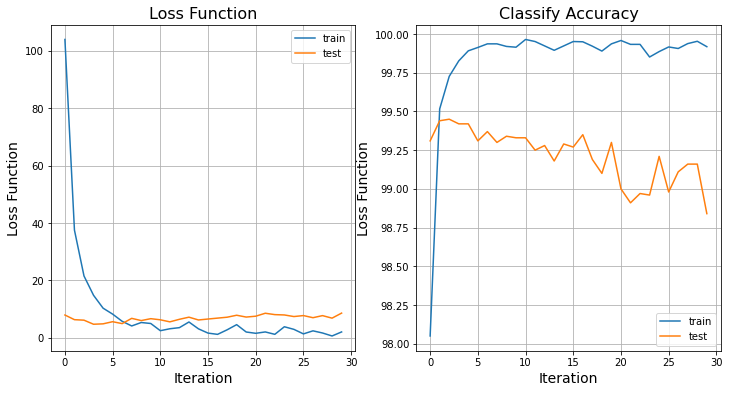

In [21]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

ax1.plot(train_loss,label="train")
ax1.plot(test_loss,label="test")

ax1.set_xlabel("Iteration",fontsize=14)
ax1.set_ylabel("Loss Function",fontsize=14)
ax1.grid(True)
ax1.set_title("Loss Function",fontsize =16)
ax1.legend()
ax2.plot(train_acc,label="train")
ax2.plot(test_acc,label="test")
ax2.set_xlabel("Iteration",fontsize=14)
ax2.set_ylabel("Loss Function",fontsize=14)
ax2.grid(True)
ax2.set_title("Classify Accuracy",fontsize =16)
ax2.legend()